# Данный ноутбук доаггегирует все данные и делает первичные попытки что-либо обучить

In [ ]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("dump.csv").rename(columns={"Unnamed: 0" : "city"})

In [34]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from sklearn.utils.optimize import newton_cg
from scipy.special import expit, exprel
from scipy.linalg import eigvalsh
from sklearn.utils.multiclass import check_classification_targets
from sklearn.linear_model.base import LinearClassifierMixin, BaseEstimator
from sklearn.utils import check_X_y
from scipy.linalg import solve_triangular
from sklearn.linear_model.logistic import ( _logistic_loss_and_grad, _logistic_loss, 
                                            _logistic_grad_hess,)



class BayesianLogisticRegression(LinearClassifierMixin, BaseEstimator):
    '''
    Superclass for two different implementations of Bayesian Logistic Regression
    ''' 
    def __init__(self, n_iter, tol, fit_intercept, verbose):
        self.n_iter        = n_iter
        self.tol           = tol
        self.fit_intercept = fit_intercept
        self.verbose       = verbose
    
    
    def fit(self,X,y):
        '''
        Fits Bayesian Logistic Regression
        Parameters
        -----------
        X: array-like of size (n_samples, n_features)
           Training data, matrix of explanatory variables
        
        y: array-like of size (n_samples, )
           Target values
           
        Returns
        -------
        self: object
           self
        '''
        # preprocess data
        X,y = check_X_y( X, y , dtype = np.float64)
        check_classification_targets(y)
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        # prepare for ovr if required        
        n_samples, n_features = X.shape
        if self.fit_intercept:
            X = self._add_intercept(X)
            
        if n_classes < 2:
            raise ValueError("Need samples of at least 2 classes")
        if n_classes > 2:
            self.coef_, self.sigma_ = [0]*n_classes,[0]*n_classes
            self.intercept_         = [0]*n_classes
        else:
            self.coef_, self.sigma_, self.intercept_ = [0],[0],[0]

        # make classifier for each class (one-vs-the rest)
        for i in range(len(self.coef_)):
            if n_classes == 2:
                pos_class = self.classes_[1]
            else:
                pos_class = self.classes_[i]
            mask = (y == pos_class)
            y_bin = np.ones(y.shape, dtype=np.float64)
            y_bin[~mask] = self._mask_val
            coef_, sigma_ = self._fit(X,y_bin)
            if self.fit_intercept:
                self.intercept_[i],self.coef_[i] = self._get_intercept(coef_)
            else:
                self.coef_[i]      = coef_
            self.sigma_[i] = sigma_
            
        self.coef_  = np.asarray(self.coef_)
        return self
        
        
    def predict_proba(self,X):
        '''
        Predicts probabilities of targets for test set
        
        Parameters
        ----------
        X: array-like of size [n_samples_test,n_features]
           Matrix of explanatory variables (test set)
           
        Returns
        -------
        probs: numpy array of size [n_samples_test]
           Estimated probabilities of target classes
        '''
        # construct separating hyperplane
        scores = self.decision_function(X)
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        # probit approximation to predictive distribution
        sigma = self._get_sigma(X)
        ks = 1. / ( 1. + np.pi*sigma / 8)**0.5
        probs = expit(scores.T*ks).T

        # handle several class cases
        if probs.shape[1] == 1:
            probs =  np.hstack([1 - probs, probs])
        else:
            probs /= np.reshape(np.sum(probs, axis = 1), (probs.shape[0],1))
        return probs
        
        
    def _add_intercept(self,X):
        '''Adds intercept to data matrix'''
        raise NotImplementedError
        
        
    def _get_intercept(self,coef):
        '''
        Extracts value of intercept from coefficients
        '''
        raise NotImplementedError
        
        
    def _get_sigma(self,X):
        '''
        Computes variance of predictive distribution (which is then used in 
        probit approximation of sigmoid)
        '''
        raise NotImplementedError



class VetrovLogisticRegression(BayesianLogisticRegression):
    '''
    Implements Bayesian Logistic Regression with type II maximum likelihood 
    (sometimes it is called Empirical Bayes), uses Gaussian (Laplace) method 
    for approximation of evidence function.
    Parameters
    ----------
    n_iter: int, optional (DEFAULT = 50)
        Maximum number of iterations before termination
        
    tol: float, optional (DEFAULT = 1e-3)
        If absolute change in precision parameter for weights is below threshold
        algorithm terminates.
        
    solver: str, optional (DEFAULT = 'lbfgs_b')
        Optimization method that is used for finding parameters of posterior
        distribution ['lbfgs_b','newton_cg']
        
    n_iter_solver: int, optional (DEFAULT = 15)
        Maximum number of iterations before termination of solver
        
    tol_solver: float, optional (DEFAULT = 1e-3)
        Convergence threshold for solver (it is used in estimating posterior
        distribution), 
    fit_intercept : bool, optional ( DEFAULT = True )
        If True will use intercept in the model. If set
        to false, no intercept will be used in calculations
        
    alpha: float (DEFAULT = 1e-6)
        Initial regularization parameter (precision of prior distribution)
        
    verbose : boolean, optional (DEFAULT = True)
        Verbose mode when fitting the model
        
    Attributes
    ----------
    coef_ : array, shape = (n_features)
        Coefficients of the regression model (mean of posterior distribution)
    sigma_ : array, shape = (n_features, )
        eigenvalues of covariance matrix
        
    alpha_: float
        Precision parameter of weight distribution
    
    intercept_: array, shape = (n_features)
        intercept
    
    References:
    -----------
    [1] Pattern Recognition and Machine Learning, Bishop (2006) (pages 293 - 294)
    '''
    
    def __init__(self, n_iter = 50, tol = 1e-3,solver = 'lbfgs_b',n_iter_solver = 15,
                 tol_solver = 1e-3, fit_intercept = True, alpha = 1,  verbose = False):
        super(VetrovLogisticRegression,self).__init__(n_iter, tol, fit_intercept, verbose)
        self.n_iter_solver     = n_iter_solver
        self.tol_solver        = tol_solver
        self.alpha             = alpha
        if solver not in ['lbfgs_b','newton_cg']:
            raise ValueError(('Only "lbfgs_b" and "newton_cg" '
                              'solvers are implemented'))
        self.solver            = solver
        # masking value (this is set for use in lbfgs_b and newton_cg)
        self._mask_val         = -1.
        

    def _fit(self,X,y):
        '''
        Maximizes evidence function (type II maximum likelihood) 
        '''
        # iterative evidence maximization
        n_samples,n_features = X.shape
        alpha = self.alpha * np.ones(n_features)
        w0 = np.zeros(n_features)
        
        for i in range(self.n_iter):
            
            alpha0 = alpha
            
            # find mean & covariance of Laplace approximation to posterior
            w, d   = self._posterior(X, y, alpha, w0) 
            
            # use Iterative updates for Bayesian Logistic Regression
            # Note in Bayesian Logistic Gull-MacKay fixed point updates 
            # and Expectation - Maximization algorithm give the same update
            # rule
            alpha = np.minimum((1 + d) / w ** 2, 1e6)
            
            
            # check convergence
            delta_alpha = sum(abs(alpha - alpha0))
            print('alpha', alpha)
            if delta_alpha < self.tol or i==self.n_iter-1:
                break
            
        # after convergence we need to find updated MAP vector of parameters
        # and covariance matrix of Laplace approximation
        self.coef_, self.sigma_ = self._posterior(X, y, alpha , w)
        self.alpha_ = alpha

        return self.coef_, self.sigma_
            

    def _add_intercept(self,X):
        '''
        Adds intercept to data (intercept column is not used in lbfgs_b or newton_cg
        it is used only in Hessian)
        '''
        return np.hstack((X,np.ones([X.shape[0],1])))
        
    
    def _get_intercept(self,coef):
        '''
        Returns intercept and coefficients
        '''
        return coef[-1], coef[:-1]
        
        
    def _get_sigma(self,X):
        ''' Compute variance of predictive distribution'''
        return np.asarray([ np.sum(X**2*s,axis = 1) for s in self.sigma_]) 
    
    def _posterior(self, X, y, alpha0, w0):
        '''
        Iteratively refitted least squares method using l_bfgs_b or newton_cg.
        Finds MAP estimates for weights and Hessian at convergence point
        '''
        n_samples,n_features  = X.shape
        assert alpha0.shape == (n_features,)
        tol = 10
        w = w0
        diag_Hess = None
        
        while tol > self.tol_solver:
            # calculate negative of Hessian at w
            
            xw    = np.dot(X, w)
            s     = expit(xw * y)
            R     = s * (1 - s)
            Hess  = np.dot(X.T*R,X)    
            Alpha = alpha0
            np.fill_diagonal(Hess, np.diag(Hess) + Alpha)
            
            z = Alpha * w - (((1-s) * y).reshape(-1, 1) * X).sum(axis=0) 
            inv_Hess = np.linalg.inv(Hess)
            diag_Hess = np.diag(inv_Hess)
            
            w_new = w - inv_Hess @ z
             
            tol = np.sum(np.abs(w_new - w))
            w = w_new
            
            print(tol)
            
        return w, diag_Hess

In [6]:
lr = VetrovLogisticRegression()

In [7]:
df.columns

Index(['city', 'road_length', 'level', 'lat', 'lon', 'county', 'salary',
       'happy', 'bars', 'hotels', 'area', 'vvp', 'population', 'humidity',
       'life', 'density', 'cold_temp_3', 'warm_temp_3', 'avg_temp', 'rain',
       'bol_all', 'koyki_all', 'alkashka', 'avg_temp_3'],
      dtype='object')

In [20]:
cols = ['road_length', 'salary',
       'happy', 'bars', 'hotels', 'area', 'vvp', 'population', 'humidity',
       'life', 'density', 'cold_temp_3', 'warm_temp_3', 'avg_temp', 'rain',
       'bol_all', 'koyki_all', 'alkashka']

In [21]:
X = df[cols].values
y = df.level.values

In [479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, Архангельск to Ярославль
Columns: 120 entries, Естественный прирост населения  за 2017 to alkashka
dtypes: float64(107), object(13)
memory usage: 60.2+ KB


In [54]:
w, sigma = lr._fit(np.hstack([np.ones((61,1)), X]), values)

0.9217010183233673
0.22119629085620263
0.08655996299813076
0.03523712661945854
0.011298460584561526
0.00029216899691173544
alpha [3.60202914e+03 1.00000000e+06 1.00000000e+06 5.93762570e+01
 1.31628217e+05 2.62218312e+04 1.00000000e+06 1.00000000e+06
 1.00000000e+06 2.01808827e+01 2.80128177e+01 1.00000000e+06
 1.83758392e+01 7.08377187e+02 4.15524055e+01 2.60445904e+04
 3.59698972e+02 1.00000000e+06 1.98257035e+02]
0.4281390969649959
0.1263267419979125
0.035084867346672814
0.0028471088248507733
0.0001541094596700104
alpha [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.23272369e+02
 1.00000000e+06 2.42038812e+05 1.00000000e+06 1.00000000e+06
 1.00000000e+06 5.69161119e+01 1.01521885e+02 1.00000000e+06
 5.21172316e+01 1.00000000e+06 1.37259328e+03 7.04798879e+04
 7.88873779e+02 1.00000000e+06 3.53120537e+02]
0.3441581898573352
0.07480577697297694
0.012409863039242729
0.00039604951924820193
alpha [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.82836664e+02
 1.00000000e+06 1.00000000e+06

In [55]:
w, sigma

(array([-1.86858330e-07, -2.48948722e-06, -9.07296686e-05, -2.80180908e-05,
         6.97674779e-05, -3.14361086e-04,  2.40354333e-05,  3.84884172e-06,
         7.71790929e-07, -5.94937668e-06, -2.18638384e-05,  3.46030290e-04,
        -2.75504653e-05, -9.25925428e-06, -1.72452385e-05, -7.27451653e-04,
         6.83217445e-02, -2.90707512e-04,  3.02776751e-05]),
 array([9.99999667e-07, 3.73643797e-09, 2.75787282e-09, 9.98980466e-07,
        5.65162972e-07, 9.40181118e-07, 1.01114112e-09, 6.06641866e-12,
        1.37471662e-12, 9.97874362e-07, 9.98142110e-07, 7.49600170e-08,
        9.99765245e-07, 9.99789337e-07, 9.99877567e-07, 6.91768488e-07,
        7.52526839e-04, 1.32589095e-08, 9.96147141e-07]))

In [56]:
from sklearn.linear_model import LogisticRegression

In [96]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X, values)

LogisticRegression(max_iter=10000)

In [60]:
lr.predict_proba(X)[:, 0]

array([6.13203691e-01, 4.80649040e-01, 4.99977090e-01, 2.52323228e-01,
       6.24618984e-01, 4.11685317e-01, 6.44439138e-01, 8.34910233e-01,
       6.41753558e-01, 5.29035553e-01, 8.21805348e-01, 3.08044238e-01,
       6.32899656e-01, 5.60186372e-01, 4.43668044e-01, 4.93133851e-01,
       4.74389650e-01, 9.35418860e-01, 5.65494895e-01, 3.23739485e-01,
       8.97238645e-01, 1.00905001e-01, 4.15818677e-01, 3.51383246e-01,
       6.50185841e-01, 9.88447326e-01, 5.14947673e-01, 7.28035609e-01,
       2.20487070e-01, 5.99643954e-01, 2.49567359e-01, 5.80134823e-01,
       2.98736248e-01, 4.78716713e-01, 3.24574376e-01, 6.31207174e-01,
       8.57162528e-01, 7.10448507e-01, 9.35921318e-01, 4.48665085e-01,
       4.62320997e-01, 4.58947387e-03, 4.12499840e-01, 6.35277420e-01,
       5.66789247e-01, 7.29985576e-01, 7.40613574e-05, 4.40207579e-01,
       6.05480440e-01, 6.53707559e-01, 4.93416521e-01, 4.51804611e-01,
       3.35485906e-01, 6.31228274e-01, 5.78327570e-01, 5.94629701e-02,
      

In [95]:
values = ((df.set_index("city").level.loc[list(X.index)] > np.median(df.set_index("city").level.loc[list(X.index)]))*1 - 0.5 ) * 2

In [48]:
np.array(cols)[w > 1e-3]

array(['bol_all'], dtype='<U11')

In [38]:
xw  = np.dot(X, w)
s   = expit(xw * y)

In [41]:
from sklearn.metrics import roc_auc_score

In [43]:
y

array([28.12908448, 29.78337812, 44.72046319, 22.8376876 , 35.55549082,
       32.11381162, 25.78590066, 17.87649869, 24.15640771, 39.05580446,
       21.63723001, 36.7497794 , 16.67894545, 34.15005372, 37.58717017,
       32.06602318, 27.18349632, 27.39033293, 22.77074813, 24.79272747,
        4.5523619 , 20.77060606, 30.52628954, 32.10796115, 24.43314831,
       16.49849985, 24.57109919, 35.85019548, 36.29149798, 20.71643044,
       28.41519026, 34.35391687, 31.17711864,  7.07639961, 35.54884541,
       29.8907153 , 14.73744407, 26.40244334, 17.8752329 , 25.26511861,
       18.55948164, 32.64179876, 27.203409  , 16.82753072, 21.89979637,
       35.11852253, 28.10127447, 55.93840859, 33.30193913, 25.76561239,
       21.77189289,  2.94406093, 45.07618948, 22.91615486, 29.78340441,
       34.43856765, 37.28946664,  3.13698641, 31.05533388, 34.76402878,
       22.45999875])

In [98]:
roc_auc_score(values, lr.predict_proba(X)[:, 1])

0.7566666666666667

In [89]:
marshrutrki = pd.read_csv("marhrutki.csv").set_index("City")
percents = marshrutrki.iloc[:, 1]
res = []
for p in percents:
    res.append(float(p[:-1].replace(" ", "")))
marshrutrki.iloc[:, 1] = res

res = []
requests = marshrutrki.iloc[:, 0]
for r in requests:
    res.append(float(r.replace(" ", "")))
marshrutrki.iloc[:, 0] = res

In [92]:
X = pd.concat([df.set_index("city"), marshrutrki.loc[df["city"]]], axis=1).drop(["lat", "level", "lon", "county", "salary", "avg_temp_3"], axis=1).dropna()

/Users/anton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [35]:
w, sigma = lr._predict_proba_lr(X)

AttributeError: 'VetrovLogisticRegression' object has no attribute 'coef_'

In [ ]:
xw = np.dot(X, w)
s  = expit(xw * y)

array([[1.00000000e+00, 1.90170000e+04, 3.97534927e+04, ...,
        5.78965517e+01, 1.40419483e+04, 5.55000000e+01],
       [1.00000000e+00, 4.17300000e+03, 2.70604571e+04, ...,
        2.50000000e+01, 7.52200000e+03, 5.86000000e+01],
       [1.00000000e+00, 2.05460000e+04, 2.11398281e+04, ...,
        1.20000000e+02, 1.97820000e+04, 6.27000000e+01],
       ...,
       [1.00000000e+00, 2.97200000e+03, 6.24390146e+04, ...,
        2.70000000e+01, 5.01400000e+03, 1.81000000e+01],
       [1.00000000e+00, 2.26260000e+04, 5.65157356e+04, ...,
        5.70000000e+01, 8.88200000e+03, 4.31000000e+01],
       [1.00000000e+00, 9.05200000e+03, 2.78796106e+04, ...,
        4.30000000e+01, 9.89700000e+03, 4.76000000e+01]])

In [498]:
df = pd.read_csv("super_puper_data_by_region.csv").rename(columns={"Unnamed: 0" : "city"})

In [499]:
df.loc[1, "city"] = "Чукотский автономный округ"
df.loc[15, "city"] = "Ямало-Ненецкий автономный округ"
df.loc[50, "city"] = "Еврейская автономная область"
df.loc[53, "city"] = "Санкт-Петербург"
df.loc[59, "city"] = "Кабардино-Балкария"
df.loc[64, "city"] = "Ханты-Мансийский автономный округ"

In [500]:
cols2017 = []
for col in df.columns:
    if col[-4:] == "2017":
        cols2017.append(col)

len(cols2017)

98

In [501]:
mapping = pd.read_csv("leha_mapping_gorod_subyekt.csv")

In [502]:
counties= list(df.city)
new_mapping = mapping.set_index("county").loc[counties].dropna().reset_index()

/Users/anton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [503]:
df = df.set_index("city").loc[new_mapping.county.values, cols2017].reset_index()

In [504]:
df["city"] = new_mapping.city

In [505]:
df = df.fillna(df.mean()).set_index("city")

In [506]:
old_dump = pd.read_csv("dump.csv").rename(columns={"Unnamed: 0" : "city"}).drop(["avg_temp_3"], axis=1).set_index("city")

In [507]:
df = pd.concat([df, old_dump], axis=1)

/Users/anton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, Архангельск to Ярославль
Columns: 120 entries, Естественный прирост населения  за 2017 to alkashka
dtypes: float64(107), object(13)
memory usage: 57.7+ KB


In [509]:
pd.set_option('display.max_rows', 150)

In [511]:
columns = df.drop(["lon", "level", "county"], axis=1).columns.tolist()
X = df.drop(["lon", "level", "county"], axis=1)
y = df.level.values.copy()

In [512]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        try:
            float(X.iloc[i, j])
        except:
            X.iloc[i,j] = float(X.iloc[i, j].replace(" ", ""))

In [515]:
X.astype(float).to_csv("final_X.csv")

In [516]:
df.level.to_csv("final_y.csv")

/Users/anton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [374]:
X = np.array(X, dtype=float)


In [389]:
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

In [258]:
lr = VetrovLogisticRegression()
values = 2 * ((y > y.mean()) - 0.5)
w, sigma = lr._fit(np.hstack([np.ones((61,1)), X]), values)

3.3198637424079607
0.01988644114351697
8.261162334416926e-06
alpha [4.87664643e+01 2.35582085e+04 2.33581854e+04 2.31152877e+04
 6.49439474e+04 7.96884725e+03 2.30829752e+04 2.32775620e+04
 2.25763797e+04 2.51877964e+04 8.46648989e+04 2.35924900e+04
 5.12538635e+04 2.11012022e+04 2.17286631e+04 2.08706768e+04
 2.05746130e+04 2.11819169e+04 2.30376112e+04 2.39555403e+04
 2.29135728e+04 2.22164725e+04 1.99434272e+04 1.96717210e+04
 2.34750352e+04 2.33130001e+04 2.33034970e+04 2.33216787e+04
 2.32123587e+04 2.34022028e+04 2.23076976e+04 2.32688429e+04
 2.45996411e+04 3.58604797e+01 2.33587513e+04 2.32326655e+04
 2.18689196e+01 2.33437719e+04 2.33673276e+04 3.59969473e+01
 2.33206517e+04 2.15822155e+01 2.27920951e+04 2.38961662e+04
 6.25756797e+02 2.32978248e+04 6.01969186e+01 5.00490934e+03
 1.41094507e+03 2.53743590e+04 2.52446157e+04 2.20269119e+04
 2.51333076e+04 2.47434409e+04 2.21959173e+04 2.10891916e+04
 2.24183524e+04 2.15716671e+04 2.34385912e+04 2.35621446e+04
 2.32827125e+04 2.

In [253]:
X.shape

(61, 116)

In [265]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10)
lr.fit(X, values)

LogisticRegression(C=10)

In [268]:
roc_auc_score(values, lr.predict_proba(X)[:, 1])

0.6627155172413793

In [269]:
from sklearn.manifold import TSNE

In [270]:
tsne = TSNE(n_components=2)

In [271]:
res = tsne.fit_transform(X)

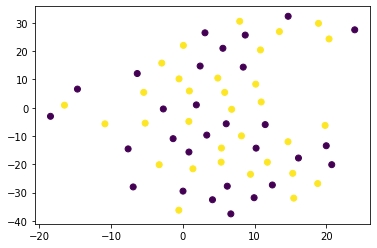

In [275]:
import matplotlib.pyplot as plt
plt.scatter(res[:, 0], res[:, 1], c=values)

In [404]:
from sklearn.ensemble import RandomForestRegressor

In [411]:
rfr = RandomForestRegressor(max_depth=1, n_estimators=100)
rfr.fit(X, y)

RandomForestRegressor(max_depth=1)

In [412]:
from sklearn.metrics import r2_score, mean_absolute_error

In [413]:
r2_score(y, rfr.predict(X))

0.17635540108601433

In [326]:
mean_absolute_error(y, rfr.predict(X))

6.225230914109191

In [328]:
fi = rfr.feature_importances_

In [414]:
np.array(columns)[fi > np.percentile(fi, 90)]

array(['Численность населения за 2017', 'Процент с ожирением  за 2017',
       'Смертность от болезней системы кровообращения  за 2017',
       'Оборот общественного питания  за 2017',
       'Потребление электроэнергии за 2017', 'road_length', 'area', 'vvp',
       'population', 'density', 'rain', 'koyki_all'], dtype='<U102')

In [336]:
from sklearn.linear_model import ElasticNet

In [401]:
lr = ElasticNet(alpha=0.01)
lr.fit(X, y)
r2_score(y, lr.predict(X))

0.07846496179536377

In [433]:
X_bol = df[["bol_all", 'koyki_all']].values

In [434]:
X_bol = (X_bol - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

In [435]:
from sklearn.linear_model import LogisticRegression

In [478]:
lr = LogisticRegression()
lr.fit(X_bol, y > y.mean())
roc_auc_score(y > y.mean(), lr.predict_proba(X_bol)[:, 1])

0.7068965517241379

In [437]:
from sklearn.metrics import roc_curve

In [ ]:
(0.25, 0.671875, 0.453125)

Text(0.5, 1.0, 'ROC Curve')

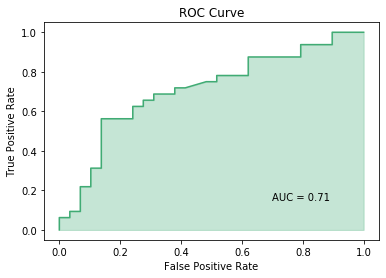

In [457]:
a, b, c = roc_curve(y > y, lr.predict_proba(X_bol)[:, 1])
plt.plot(a, b, color=(0.25, 0.671875, 0.453125))
plt.fill_between(a, 0, b, color=(0.25, 0.671875, 0.453125, 0.3))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0.7, 0.15, "AUC = 0.71" )
plt.title("ROC Curve")

In [393]:
np.array(columns)[np.abs(lr.coef_) > 0.01]

array(['Численность населения за 2017', 'Процент с ожирением  за 2017',
       'Доходы: Медианный доход на душу населения за 2017',
       'Доходы: Средний доход на душу населения за 2017',
       'Зарплаты: медианная за 2017', 'Зарплаты: средняя за 2017',
       'Оборот общественного питания  за 2017',
       'Оборот розничной торговли на душу населения в постоянных ценах  за 2017',
       'Потребление электроэнергии за 2017', 'road_length', 'area', 'vvp',
       'population', 'density', 'koyki_all'], dtype='<U102')

In [458]:
from scipy.stats import spearmanr

In [ ]:
from sklea

In [474]:
rhos, pvals = [], []
res = []
for col in columns + ["lat", "lon"]:
    rho, pval = spearmanr(y, df[col].values)
    rhos.append(rho)
    pvals.append(pval)
    res.append([rho, pval])

In [475]:
res_spe = pd.DataFrame(data=res, columns=["rho", "pval"], index=columns + ["lat", "lon"])

In [476]:
res_spe.sort_values(by="pval")

,rho,pval
lat,0.316023,0.013098
Миграционный прирост населения за 2017,-0.273536,0.032920
warm_temp_3,-0.272308,0.033746
2. Процент не раскрытых преступлений средней тяжести за 2017,-0.259718,0.043246
avg_temp,-0.249441,0.052543
Трудовая миграция между регионами: процент работающих в других регионах за 2017,0.247974,0.053994
Смертность от болезней органов пищеварения за 2017,0.243951,0.058140
humidity,0.232045,0.071942
area,-0.231320,0.072861
Количество преступников — женщин: доля от общего числа преступников за 2017,0.223444,0.083449
